In [8]:
import math
from datetime import date, timedelta

import pandas as pd

from demeter import TokenInfo, Actuator, Strategy, RowData, simple_moving_average, ChainType, MarketInfo, PeriodTrigger, \
    BaseAction
from demeter.result import performance_metrics
from demeter.uniswap import UniV3Pool, UniLpMarket
from typing import List
from demeter.broker import AccountStatus
from matplotlib.pylab import plt
import matplotlib.dates as mdates
#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


In [9]:
from demeter.indicator.common import get_real_n

In [10]:
def volume_weighted_moving_average(
    data: pd.Series | pd.DataFrame,
    window: timedelta = timedelta(hours=5),
    min_periods: int | None = None,
    center: bool = False,
    win_type: str | None = None,
    on: str | None = None,
    closed: str | None = None,
    method: str = "single",
) -> pd.Series:
    """
    calculate volume weighted moving average

    docs for other params, see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    :param data: Pandas datarame
    :type data: Series
    :param window: window width
    :type window: timedelta
    :return: volume weighted moving average
    :rtype: Series

    """
    volume = abs(data["netAmount0"].astype(np.float64))
    price = data["price"].astype(np.float64)
    price_volume = volume * price
    rolling_price_volume = price_volume.rolling(
        window=get_real_n(price_volume, window),
        min_periods=min_periods,
        center=center,
        win_type=win_type,
        on=on,
        closed=closed,
        method=method,
    ).sum()
    rolling_volume = volume.rolling(
        window=get_real_n(volume, window),
        min_periods=min_periods,
        center=center,
        win_type=win_type,
        on=on,
        closed=closed,
        method=method,
    ).sum()
    return rolling_price_volume / rolling_volume

In [11]:
class MovingAverageStrategy(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """

        # Add a simple moving average line for backtesting data. In backtesting,
        # we will add/remove liquidity according to this line.
        self.add_column(market_key, "sma", simple_moving_average(self.data[market_key].price, window=timedelta(hours=1)))
        # self.add_column(market_key, "vwma", volume_weighted_moving_average(self.data[market_key].price, window=timedelta(hours=1)))
        self.net_value_before_bar = 0
        self.net_value_diff_list = []
        # Register a trigger, every day, we split both assets into two shares of equal value
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=3), trigger_immediately=True, do=self.rebalance))

    def rebalance(self, row_data: RowData):
        self.markets[market_key].even_rebalance(row_data.market_status[market_key].price)

    """
    After a test is executed, actuator will loop the data, and bar series functions will be called on every time.
    Here you can set conditions and execute liquidity operations
    """

    def on_bar(self, row_data: RowData):
        """
        This function is called after trigger, but before market is updated(Fees will be distributed in this step).
        """
        lp_market: UniLpMarket = self.markets[market_key]
        current_price = row_data.market_status[market_key].price
        # get moving average price, if value is nan, fill it with current price
        # ma_price = self.data[market_key].loc[row_data.timestamp]["vwma"]
        ma_price = self.data[market_key].loc[row_data.timestamp]["sma"]
        ma_price = row_data.market_status[market_key].price if math.isnan(ma_price) else ma_price

        # this is a nonsense strategy, just to show how to trigger actions
        if row_data.market_status[market_key].price > ma_price  and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price, current_price + 100)
        elif row_data.market_status[market_key].price < ma_price  and len(self.markets[market_key].positions) < 1:
            lp_market.remove_all_liquidity()
            lp_market.add_liquidity(current_price - 100, current_price)

    def after_bar(self, row_data: RowData):
        """
        this function is called after market has updated.
        """
        timestamp = row_data.timestamp
        net_value_after_bar = self.broker.get_account_status(self.prices.loc[timestamp]).net_value
        net_value_diff = net_value_after_bar - self.net_value_before_bar
        self.net_value_diff_list.append(net_value_diff)

    def finalize(self):
        """
        Call when main loop finished. some statistic work can be executed here
        """
        self.data[market_key]["diff"] = self.net_value_diff_list
        pass

    def notify(self, action: BaseAction):
        """
        When a new action(add/remove liquidity) is executed, you can be notified by this call back.
        """
        print("\n")
        print(action.timestamp, action.action_type.value)

In [12]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("uniswap_eth_udsc")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = MovingAverageStrategy()

market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 2),
                date(2024, 8, 1))
actuator.set_price(market.get_price_from_data())
actuator.run()

2024-10-06 22:24:56,329 - INFO - start load files from 2024-07-02 to 2024-08-01...
2024-10-06 22:24:56,490 - INFO - load file complete, preparing...
2024-10-06 22:24:56,985 - INFO - data has been prepared
2024-10-06 22:24:57,014 - INFO - Qute token is USDC
2024-10-06 22:24:57,014 - INFO - init strategy...
2024-10-06 22:24:57,031 - INFO - start main loop...
  3%|██▊                                                                                                       | 1174/44640 [00:00<00:07, 5946.23it/s]



2024-07-02 00:00:00 buy


2024-07-02 00:59:00 add_liquidity


 10%|██████████▌                                                                                               | 4451/44640 [00:00<00:06, 6496.46it/s]



2024-07-05 00:00:00 buy


 20%|█████████████████████▏                                                                                    | 8931/44640 [00:01<00:05, 6085.86it/s]



2024-07-08 00:00:00 buy


 31%|████████████████████████████████▊                                                                        | 13960/44640 [00:02<00:05, 6059.62it/s]



2024-07-11 00:00:00 sell


 41%|███████████████████████████████████████████▎                                                             | 18393/44640 [00:03<00:04, 5785.29it/s]



2024-07-14 00:00:00 sell


 51%|█████████████████████████████████████████████████████▏                                                   | 22619/44640 [00:03<00:03, 5729.33it/s]



2024-07-17 00:00:00 sell


 60%|██████████████████████████████████████████████████████████████▉                                          | 26771/44640 [00:04<00:03, 5291.25it/s]



2024-07-20 00:00:00 sell


 69%|████████████████████████████████████████████████████████████████████████▍                                | 30787/44640 [00:05<00:03, 4196.06it/s]



2024-07-23 00:00:00 buy


 80%|███████████████████████████████████████████████████████████████████████████████████▉                     | 35701/44640 [00:06<00:01, 6180.36it/s]



2024-07-26 00:00:00 buy


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 40153/44640 [00:07<00:00, 6356.33it/s]



2024-07-29 00:00:00 sell


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 43977/44640 [00:07<00:00, 6080.18it/s]



2024-08-01 00:00:00 buy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:07<00:00, 5685.63it/s]
2024-10-06 22:25:04,916 - INFO - main loop finished
2024-10-06 22:25:05,297 - INFO - Print actuator summary
2024-10-06 22:25:05,407 - INFO - Backtesting finished, execute time 8.400859832763672s


Final account status                              
Token balance in broker       
USDC      :514.46873                ETH       :0.15920480               
Position value in markets     
uniswap_eth_udsc(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1         liquidity
0      194600      194880  28.501398  0.0082780681  1226410619020315

Quote by: USDC
Account balance history                           
l1                  net_value    tokens            uniswap_eth_udsc  \
l2                                 USDC        ETH        net_value   
2024-07-02 00:00:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:01:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:02:00 1999.0001 999.74981 0.29057598                0   
2024-07-02 00:03:00 1999.0001 999.74981 0.29057598                0

In [10]:
# simple_moving_average(actuator.strategy.data[market_key].price)

What about using a dollar bar or volume bar instead of a minute data? We could use Intrinsic Entropy Model to estiamte volatilty?

In [49]:

def plot_data():
    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot price, sma_1h, and sma_6h on the primary y-axis
    ax1.plot(df.index, df['price'], label='Price', color='blue')
    ax1.plot(df.index, df['kama'], label='kama', color='green')
    ax1.plot(df.index, df['sma_6h'], label='SMA 6h', color='red')

    # Set up the primary y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price / SMA')
    ax1.tick_params(axis='y')

    # Create a secondary y-axis for volatility
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['volatility_12h'], label='volatility_12h', color='purple', alpha=0.5)
    ax2.plot(df.index, df['volatility_1d'], label='volatility_1d', color='y', alpha=0.5)
    ax2.set_ylabel('Volatility')
    ax2.tick_params(axis='y')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # Format the date on the x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

    plt.title('Price, SMAs, and Volatility Over Time')
    plt.tight_layout()
    plt.show()

In [11]:
from demeter import realized_volatility

In [13]:
df = actuator.strategy.data[market_key]

In [15]:
df['volume1'].max()

Decimal('3936.978121020261951254')

In [53]:
df['kama'] = df['kama'].replace(0, np.nan)

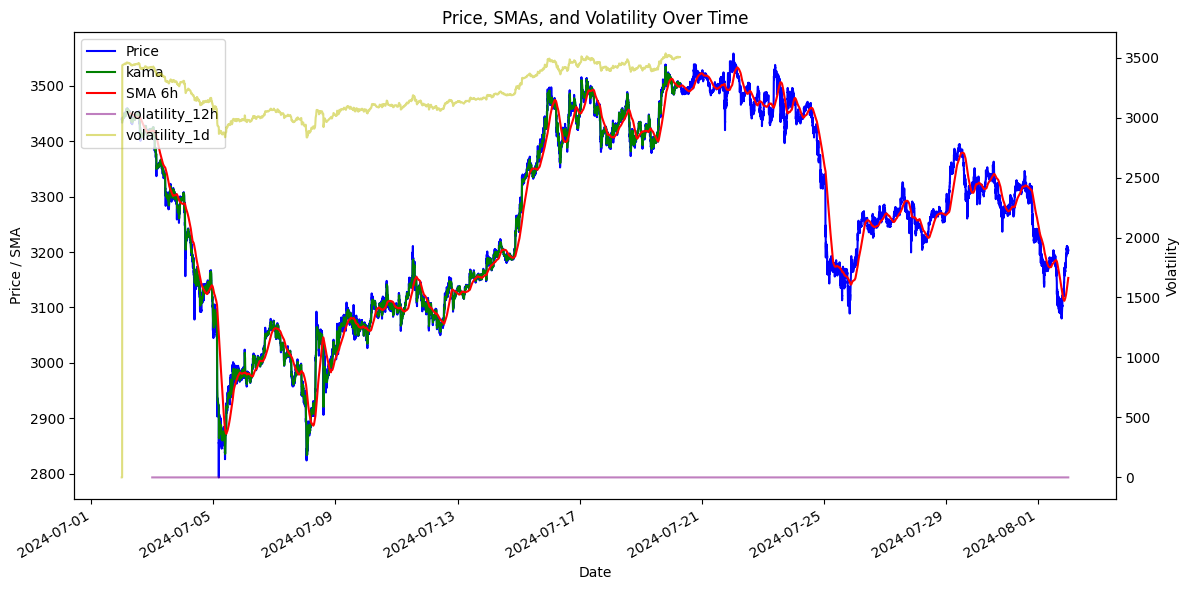

In [54]:
plot_data()

In [13]:
## How do we decide how big the interval should be ? 
# - we could use realized volatility to estiamte the size of the interval 
# - the interval should not be even but based on trend should skew to one side 
# 

In [58]:
import numpy as np
def calculate_kama_log(data, er_period=10, fast_period=2, slow_period=30):
    log_returns = np.log(data / data.shift(1))
    abs_log_returns = np.abs(log_returns)
    
    volatility = abs_log_returns.rolling(window=er_period).sum()
    efficiency_ratio = np.abs(log_returns.rolling(window=er_period).sum()) / volatility
    
    smoothing_constant = (efficiency_ratio * (2.0/(fast_period+1) - 2.0/(slow_period+1)) + 2.0/(slow_period+1))**2
    
    kama = np.zeros_like(data)
    kama[er_period] = data[er_period]
    for i in range(er_period + 1, len(data)):
        kama[i] = np.exp(np.log(kama[i-1]) + smoothing_constant[i] * log_returns[i])
    
    return pd.Series(kama, index=data.index)

In [38]:
df['price'] = df['price'].astype(np.float64)

In [64]:
df['kama'] = calculate_kama(df['price'], er_period=30)

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_86469/3585904390.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[er_period] = data[er_period]
/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_86469/3585904390.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + smoothing_constant[i] * (data[i] - kama[i-1])


In [ ]:
## Some things to consider
# Users look at:
# - price sentiment
# - risk profile - conservative, aggressive, highly aggressive
    # - price range 
# - time horizon 
    # - time in the market max


In [68]:
def calculate_continuous_ama(data, time_window='4H', fast_window='30min', slow_window='1D'):
    """
    Calculate the Adaptive Moving Average (AMA) for continuous 24/7 data
    
    :param data: pandas Series of price data with DatetimeIndex at minute intervals
    :param time_window: time window for efficiency ratio calculation
    :param fast_window: time window for fastest EMA constant
    :param slow_window: time window for slowest EMA constant
    :return: pandas Series of AMA values
    """
    # Convert time windows to number of minutes
    n = pd.Timedelta(time_window).total_seconds() // 60
    fast = pd.Timedelta(fast_window).total_seconds() // 60
    slow = pd.Timedelta(slow_window).total_seconds() // 60
    
    changes = data.diff().abs()
    
    volatility = changes.rolling(window=n).sum()
    direction = (data - data.shift(n)).abs()
    
    efficiency_ratio = direction / volatility
    fastest = 2.0 / (fast + 1)
    slowest = 2.0 / (slow + 1)
    
    sc = (efficiency_ratio * (fastest - slowest) + slowest) ** 2
    
    ama = pd.Series(index=data.index, dtype=float)
    ama.iloc[0] = data.iloc[0]
    
    for i in range(1, len(data)):
        ama.iloc[i] = ama.iloc[i-1] + sc.iloc[i] * (data.iloc[i] - ama.iloc[i-1])
    
    return ama.rename('AMA')

In [ ]:
# start with a simple strategy with crossing moving average 
# base your range on volatility - how? 
# would RSI work in arbitrage filled market? 
# volume weighted moving average could be interesting 

In [80]:
pd.set_option('display.max_columns', 500)

<Axes: >

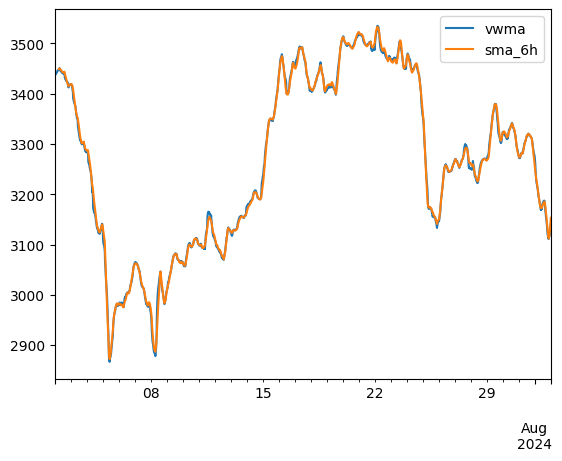

In [101]:
df.plot(y=['vwma','sma_6h'])

In [99]:
df

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1,sma,diff,sma_1h,sma_6h,volatility,volatility_1d,volatility_12h,kama,pv,cumulative_pv,cumulative_volume,vwap,vwma
2024-07-02 00:00:00,-59645838470,17345402519575340395,194886.0,194885.0,194885.0,194886.0,0,17345402519575340395,19604866381108097039,3440.9245402970851926409910188694417,3440.580482,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,0,17.345402519575340395,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.000000,2.052163e+14,2.052163e+14,5.964584e+10,3440.580482,3440.580482
2024-07-02 00:01:00,5902489506,-1713724919638445944,194886.0,194886.0,194886.0,194886.0,9761456799,1122266415802469747,19604866381108097039,3440.5804822488603066103299858708544,3440.580482,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,9761.456799,1.122266415802469747,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.000000,2.030799e+13,2.255243e+14,6.554833e+10,3440.580482,3440.580482
2024-07-02 00:02:00,-266698157080,77579135165690617297,194891.0,194887.0,194887.0,194891.0,1138500000,77909912233626236696,19564312406612336837,3440.2364586030000066096690189689593,3438.860708,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,1138.5,77.909912233626236696,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000,9.171378e+14,1.142662e+15,3.322465e+11,3439.199999,3439.199999
2024-07-02 00:03:00,397928385,-115332650372234652,194891.0,194891.0,194891.0,194891.0,1533457345,330386568300773025,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1533.457345,0.330386568300773025,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000,1.368420e+12,1.144031e+15,3.326444e+11,3439.199593,3439.199593
2024-07-02 00:04:00,-1257981760,366337156837051095,194891.0,194891.0,194891.0,194891.0,1108817933,688628792423050930,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1108.817933,0.68862879242305093,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000,4.326024e+12,1.148357e+15,3.339024e+11,3439.198317,3439.198317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01 23:55:00,7502957480,-2341579722406542297,195602.0,195602.0,195602.0,195602.0,7502957480,0,7406507501884618180,3202.8587864419291118006138564495336,3202.858786,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,7502.95748,0,3204.958808,2010.0679535012531642107577137041396,3204.958808,3152.215443,0.016200,NaN,0.009655,3202.659660,2.403091e+13,1.967044e+19,5.897772e+15,3335.231457,3142.004342
2024-08-01 23:56:00,-143045686,44686671883545918,195602.0,195602.0,195602.0,195602.0,0,44686671883545918,7406507501884618180,3202.8587864419291118006138564495336,3202.858786,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,0,0.044686671883545918,3204.926771,2010.0679535012531642107577137041396,3204.926771,3152.477508,0.016206,NaN,0.009675,3202.660721,4.581551e+11,1.967044e+19,5.897772e+15,3335.231454,3142.015304
2024-08-01 23:57:00,-903133202,282134461825650765,195602.0,195602.0,195602.0,195602.0,0,282134461825650765,7406507501884618180,3202.8587864419291118006138564495336,3202.858786,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,0,0.282134461825650765,3204.873366,2010.0679535012531642107577137041396,3204.873366,3152.740436,0.016212,NaN,0.009694,3202.661777,2.892608e+12,1.967044e+19,5.897773e+15,3335.231433,3142.023524
2024-08-01 23:58:00,619031678,-192988492245276893,195602.0,195602.0,195602.0,195602.0,1262027285,200869316408788789,7406507501884618180,3202.8587864419291118006138564495336,3202.858786,3202.85878644

In [89]:
price

2024-07-02 00:00:00    3440.580482
2024-07-02 00:01:00    3440.580482
2024-07-02 00:02:00    3438.860708
2024-07-02 00:03:00    3438.860708
2024-07-02 00:04:00    3438.860708
                          ...     
2024-08-01 23:55:00    3202.858786
2024-08-01 23:56:00    3202.858786
2024-08-01 23:57:00    3202.858786
2024-08-01 23:58:00    3202.858786
2024-08-01 23:59:00    3202.858786
Freq: min, Name: price, Length: 44640, dtype: float64

In [90]:
vwp

2024-07-02 00:00:00    3440.580482
2024-07-02 00:01:00    3440.580482
2024-07-02 00:02:00    3438.860708
2024-07-02 00:03:00    3438.860708
2024-07-02 00:04:00    3438.860708
                          ...     
2024-08-01 23:55:00    3202.858786
2024-08-01 23:56:00    3202.858786
2024-08-01 23:57:00    3202.858786
2024-08-01 23:58:00    3202.858786
2024-08-01 23:59:00            NaN
Freq: min, Length: 44640, dtype: float64

In [82]:
df.head(10)

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1,sma,diff,sma_1h,sma_6h,volatility,volatility_1d,volatility_12h,kama
2024-07-02 00:00:00,-59645838470,17345402519575340395,194886.0,194885.0,194885.0,194886.0,0,17345402519575340395,19604866381108097039,3440.9245402970851926409910188694417,3440.580482,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,0,17.345402519575340395,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:01:00,5902489506,-1713724919638445944,194886.0,194886.0,194886.0,194886.0,9761456799,1122266415802469747,19604866381108097039,3440.5804822488603066103299858708544,3440.580482,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,9761.456799,1.122266415802469747,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:02:00,-266698157080,77579135165690617297,194891.0,194887.0,194887.0,194891.0,1138500000,77909912233626236696,19564312406612336837,3440.2364586030000066096690189689593,3438.860708,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,1138.5,77.909912233626236696,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:03:00,397928385,-115332650372234652,194891.0,194891.0,194891.0,194891.0,1533457345,330386568300773025,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1533.457345,0.330386568300773025,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:04:00,-1257981760,366337156837051095,194891.0,194891.0,194891.0,194891.0,1108817933,688628792423050930,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1108.817933,0.68862879242305093,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:05:00,-3660766796,1065148519303882034,194891.0,194891.0,194891.0,194891.0,102436126,1094923131775370573,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,102.436126,1.094923131775370573,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:06:00,-22709516234,6607746011123589677,194891.0,194891.0,194891.0,194891.0,497993255,6752496580374621405,19564312406612336837,3438.8607079744119766363274444637814,3438.860708,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,497.993255,6.752496580374621405,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:07:00,-2730624625,794541155773097271,194892.0,194891.0,194891.0,194892.0,55506487,810675672264463811,19564312406612336837,3438.8607079744119766363274444637814,3438.516856,3438.8607079744119766363274444637814,3438.5168562887830983264947949842851,55.506487,0.810675672264463811,NaN,1998.9002347602600012145254730364051,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:08:00,-56880472325,16552981491584229481,194893.0,194893.0,194893.0,194893.0,5882205100,18262986899624603648,19564312406612336837,3438.1730389848846098655082441598678,3438.173039,3438.1730389848846098655082441598678,3438.1730389848846098655082441598678,5882.2051,18.262986899624603648,NaN,1998.8003297085313312824703944232150,NaN,NaN,NaN,0.0,NaN,0.0
2024-07-02 00:09:00,-272533546878,79325501447055194242,194897.0,194893.0,194893.0,194897.0,0,79325501447055194242,19564312406612336837,3438.1730389848846098655082441598678,3436.798114,3438.1730389848846098655082441598678,3436.7981135178431254108736457631903,0,79.325501447055194242,NaN,1998.4008093866908659958742706616188,NaN,NaN,NaN,0.0,NaN,0.0


In [77]:
simple_moving_average(df.price, window=timedelta(hours=5))

2024-07-02 00:00:00            NaN
2024-07-02 00:01:00            NaN
2024-07-02 00:02:00            NaN
2024-07-02 00:03:00            NaN
2024-07-02 00:04:00            NaN
                          ...     
2024-08-01 23:55:00    3162.722602
2024-08-01 23:56:00    3163.099061
2024-08-01 23:57:00    3163.475520
2024-08-01 23:58:00    3163.849919
2024-08-01 23:59:00    3164.235642
Freq: min, Name: price, Length: 44640, dtype: float64

In [78]:
df.price.rolling(5).sum()

2024-07-02 00:00:00             NaN
2024-07-02 00:01:00             NaN
2024-07-02 00:02:00             NaN
2024-07-02 00:03:00             NaN
2024-07-02 00:04:00    17197.743088
                           ...     
2024-08-01 23:55:00    16014.293964
2024-08-01 23:56:00    16013.973678
2024-08-01 23:57:00    16014.293932
2024-08-01 23:58:00    16014.293932
2024-08-01 23:59:00    16014.293932
Freq: min, Name: price, Length: 44640, dtype: float64

In [71]:
df

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,...,volume0,volume1,sma,diff,sma_1h,sma_6h,volatility,volatility_1d,volatility_12h,kama
2024-07-02 00:00:00,-59645838470,17345402519575340395,194886.0,194885.0,194885.0,194886.0,0,17345402519575340395,19604866381108097039,3440.9245402970851926409910188694417,...,0,17.345402519575340395,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.000000
2024-07-02 00:01:00,5902489506,-1713724919638445944,194886.0,194886.0,194886.0,194886.0,9761456799,1122266415802469747,19604866381108097039,3440.5804822488603066103299858708544,...,9761.456799,1.122266415802469747,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN,0.0,NaN,0.000000
2024-07-02 00:02:00,-266698157080,77579135165690617297,194891.0,194887.0,194887.0,194891.0,1138500000,77909912233626236696,19564312406612336837,3440.2364586030000066096690189689593,...,1138.5,77.909912233626236696,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000
2024-07-02 00:03:00,397928385,-115332650372234652,194891.0,194891.0,194891.0,194891.0,1533457345,330386568300773025,19564312406612336837,3438.8607079744119766363274444637814,...,1533.457345,0.330386568300773025,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000
2024-07-02 00:04:00,-1257981760,366337156837051095,194891.0,194891.0,194891.0,194891.0,1108817933,688628792423050930,19564312406612336837,3438.8607079744119766363274444637814,...,1108.817933,0.68862879242305093,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01 23:55:00,7502957480,-2341579722406542297,195602.0,195602.0,195602.0,195602.0,7502957480,0,7406507501884618180,3202.8587864419291118006138564495336,...,7502.95748,0,3204.958808,2010.0679535012531642107577137041396,3204.958808,3152.215443,0.016200,NaN,0.009655,3202.659660
2024-08-01 23:56:00,-143045686,44686671883545918,195602.0,195602.0,195602.0,195602.0,0,44686671883545918,7406507501884618180,3202.8587864419291118006138564495336,...,0,0.044686671883545918,3204.926771,2010.0679535012531642107577137041396,3204.926771,3152.477508,0.016206,NaN,0.009675,3202.660721
2024-08-01 23:57:00,-903133202,282134461825650765,195602.0,195602.0,195602.0,195602.0,0,282134461825650765,7406507501884618180,3202.8587864419291118006138564495336,...,0,0.282134461825650765,3204.873366,2010.0679535012531642107577137041396,3204.873366,3152.740436,0.016212,NaN,0.009694,3202.661777
2024-08-01 23:58:00,619031678,-192988492245276893,195602.0,195602.0,195602.0,195602.0,1262027285,200869316408788789,7406507501884618180,3202.8587864419291118006138564495336,...,1262.027285,0.200869316408788789,3204.819961,2010.0679535012531642107577137041396,3204.819961,3152.987810,0.016218,NaN,0.009713,3202.663109


In [ ]:
# What to consider:
# - price range
    # - volatility
    # - trend 
# - duration
    # - LVR 
# - trading volume
    # - can we somehow account for this ? 
# - LP can be assymetric, maybe actually should be due to trend 

# - could we use RL or NN to predict range width based on indicators ? 
        # - probably way better to start with OLS 
#   - problems could be that we do not know trading volume as this may be independent of price movements
#   - volatility and trading volume are probably very correlated (to check)
#   - could we use GARCH or ARIMA for volatility prediction ? 

In [ ]:
def 

In [69]:
calculate_continuous_ama(df['price'])

/var/folders/11/llb_31fx359c3jzc04q5rklh0000gn/T/ipykernel_86469/2457373751.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  n = pd.Timedelta(time_window).total_seconds() // 60


ValueError: window must be an integer 0 or greater

In [55]:
change = np.abs(df['price'] - df['price'].shift(1))
volatility = change.rolling(window=10).sum()

In [47]:
actuator.strategy.add_column(market_key, "volatility_1d", df['kama'])

In [24]:
actuator.strategy.add_column(market_key, "sma_1h", simple_moving_average(actuator.strategy.data[market_key].price, window=timedelta(hours=1)))
actuator.strategy.add_column(market_key, "sma_6h", simple_moving_average(actuator.strategy.data[market_key].price, window=timedelta(hours=6)))
actuator.strategy.add_column(market_key, "volatility_12h", realized_volatility(actuator.strategy.data[market_key].price, timedelta(hours=12), timedelta(hours=12)))
actuator.strategy.add_column(market_key, "volatility_1d", realized_volatility(actuator.strategy.data[market_key].price, timedelta(days=1), timedelta(days=1)))

In [25]:
df = actuator.strategy.data[market_key]

In [26]:
df.tail(2)

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,...,high,volume0,volume1,sma,diff,sma_1h,sma_6h,volatility,volatility_1d,volatility_12h
2024-08-01 23:58:00,619031678,-192988492245276893,195602.0,195602.0,195602.0,195602.0,1262027285,200869316408788789,7406507501884618180,3202.8587864419291118006138564495336,...,3202.8587864419291118006138564495336,1262.027285,0.200869316408788789,3204.819961,2010.0679535012531642107577137041396,3204.819961,3152.987810,0.016218,0.016218,0.009713
2024-08-01 23:59:00,0,0,195602.0,195602.0,195602.0,195602.0,0,0,7406507501884618180,3202.8587864419291118006138564495336,...,3202.8587864419291118006138564495336,0,0,3204.777241,2010.0679535012531642107577137041396,3204.777241,3153.231724,0.016224,0.016224,0.009733


In [16]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_log_returns(prices):
    return np.log(prices / prices.shift(1)).dropna()

def estimate_entropy(returns, num_bins=100):
    counts, _ = np.histogram(returns, bins=num_bins)
    probabilities = counts / len(returns)
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

def entropy_to_volatility(entropy, scaling_factor=1.0):
    # This is a simplified relationship. In practice, you'd need to calibrate this.
    return scaling_factor * np.sqrt(entropy)

def estimate_volatility(prices, window=30, num_bins=100, scaling_factor=.8):
    returns = calculate_log_returns(prices)
    entropy = returns.rolling(window=window).apply(lambda x: estimate_entropy(x, num_bins))
    return entropy_to_volatility(entropy, scaling_factor)

In [19]:
df

,netAmount0,netAmount1,closeTick,openTick,lowestTick,highestTick,inAmount0,inAmount1,currentLiquidity,open,price,low,high,volume0,volume1,sma,diff,sma_1h,sma_6h,volatility
2024-07-02 00:00:00,-59645838470,17345402519575340395,194886.0,194885.0,194885.0,194886.0,0,17345402519575340395,19604866381108097039,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,3440.9245402970851926409910188694417,3440.5804822488603066103299858708544,0,17.345402519575340395,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN
2024-07-02 00:01:00,5902489506,-1713724919638445944,194886.0,194886.0,194886.0,194886.0,9761456799,1122266415802469747,19604866381108097039,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,3440.5804822488603066103299858708544,9761.456799,1.122266415802469747,NaN,1999.4998749062109160053658421312631,NaN,NaN,NaN
2024-07-02 00:02:00,-266698157080,77579135165690617297,194891.0,194887.0,194887.0,194891.0,1138500000,77909912233626236696,19564312406612336837,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,3440.2364586030000066096690189689593,3438.8607079744119766363274444637814,1138.5,77.909912233626236696,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN
2024-07-02 00:03:00,397928385,-115332650372234652,194891.0,194891.0,194891.0,194891.0,1533457345,330386568300773025,19564312406612336837,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1533.457345,0.330386568300773025,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN
2024-07-02 00:04:00,-1257981760,366337156837051095,194891.0,194891.0,194891.0,194891.0,1108817933,688628792423050930,19564312406612336837,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,3438.8607079744119766363274444637814,1108.817933,0.68862879242305093,NaN,1999.0001498024938440135737571574555,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01 23:55:00,7502957480,-2341579722406542297,195602.0,195602.0,195602.0,195602.0,7502957480,0,7406507501884618180,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,7502.95748,0,3204.958808,2010.0679535012531642107577137041396,3204.958808,3152.215443,0.016200
2024-08-01 23:56:00,-143045686,44686671883545918,195602.0,195602.0,195602.0,195602.0,0,44686671883545918,7406507501884618180,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,0,0.044686671883545918,3204.926771,2010.0679535012531642107577137041396,3204.926771,3152.477508,0.016206
2024-08-01 23:57:00,-903133202,282134461825650765,195602.0,195602.0,195602.0,195602.0,0,282134461825650765,7406507501884618180,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,0,0.282134461825650765,3204.873366,2010.0679535012531642107577137041396,3204.873366,3152.740436,0.016212
2024-08-01 23:58:00,619031678,-192988492245276893,195602.0,195602.0,195602.0,195602.0,1262027285,200869316408788789,7406507501884618180,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,3202.8587864419291118006138564495336,1262.027285,0.200869316408788789,3204.819961,2010.0679535012531642107577137041396,3204.819961,3152.987810,0.016218


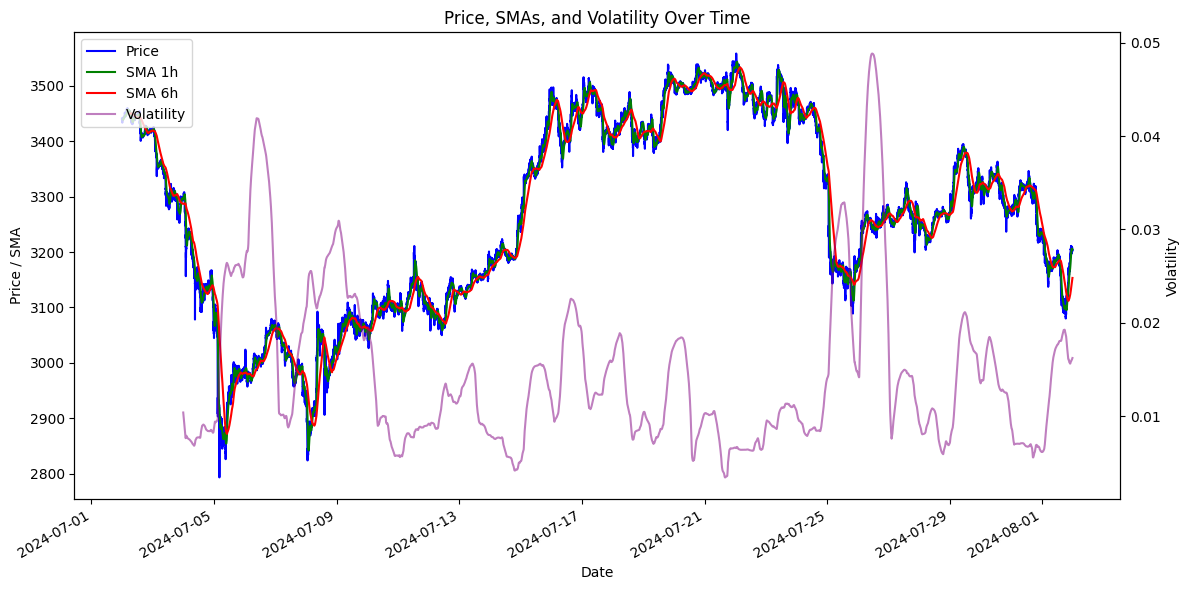

2024-10-06 11:49:09,157 - INFO - Qute token is USDC
2024-10-06 11:49:09,158 - INFO - init strategy...
2024-10-06 11:49:09,181 - INFO - start main loop...
  3%|██▉                                                                                                       | 1253/44640 [00:00<00:06, 6315.47it/s]



2024-07-02 00:00:00 buy


2024-07-02 00:59:00 add_liquidity


 10%|██████████▊                                                                                               | 4567/44640 [00:00<00:08, 4832.69it/s]



2024-07-05 00:00:00 buy


 22%|██████████████████████▊                                                                                   | 9604/44640 [00:01<00:06, 5327.79it/s]



2024-07-08 00:00:00 buy


 31%|████████████████████████████████▊                                                                        | 13970/44640 [00:02<00:05, 5510.15it/s]



2024-07-11 00:00:00 sell


 41%|██████████████████████████████████████████▊                                                              | 18224/44640 [00:03<00:04, 5744.24it/s]



2024-07-14 00:00:00 sell


 50%|████████████████████████████████████████████████████▊                                                    | 22435/44640 [00:04<00:04, 5310.99it/s]



2024-07-17 00:00:00 sell


 60%|██████████████████████████████████████████████████████████████▌                                          | 26614/44640 [00:04<00:03, 4920.44it/s]



2024-07-20 00:00:00 sell


 70%|█████████████████████████████████████████████████████████████████████████▋                               | 31349/44640 [00:05<00:02, 5702.18it/s]



2024-07-23 00:00:00 buy


 80%|███████████████████████████████████████████████████████████████████████████████████▌                     | 35511/44640 [00:06<00:01, 5316.95it/s]



2024-07-26 00:00:00 buy


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 39766/44640 [00:07<00:00, 5561.62it/s]



2024-07-29 00:00:00 sell


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████ | 44243/44640 [00:07<00:00, 6329.90it/s]



2024-08-01 00:00:00 buy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 44640/44640 [00:08<00:00, 5563.69it/s]
2024-10-06 11:49:17,205 - INFO - main loop finished
2024-10-06 11:49:17,593 - INFO - Print actuator summary
2024-10-06 11:49:17,701 - INFO - Backtesting finished, execute time 8.546702861785889s


Final account status                              
Token balance in broker       
USDC      :514.46873                ETH       :0.15920480               
Position value in markets     
uniswap_eth_udsc(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0      pending1         liquidity
0      194600      194880  28.501398  0.0082780681  1226410619020315

Quote by: USDC
Account balance history                           
l1                  net_value    tokens            uniswap_eth_udsc  \
l2                                 USDC        ETH        net_value   
2024-07-02 00:00:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:01:00 1999.4999 999.74981 0.29057598                0   
2024-07-02 00:02:00 1999.0001 999.74981 0.29057598                0   
2024-07-02 00:03:00 1999.0001 999.74981 0.29057598                0

In [ ]:
# print({k: v for k, v in performance_metrics(
#     actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
# ).items()})
# plot_position_return_decomposition(actuator.account_status_df, actuator.token_prices[eth.name], market_key)